In [ ]:
import sys
!{sys.executable} -m pip install tensorflow

In [4]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import psycopg2
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [5]:
db_host = ""
db_port = ""
db_database = ""
db_user = ""
db_passwd = ""

In [6]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://'+db_user+':'+db_passwd+'@'+db_host+':'+db_port+'/'+db_database+'')

In [7]:
df = pd.read_sql_query('SELECT * FROM price ORDER BY ts DESC LIMIT 10000',con=engine)

In [8]:
df['_dt'] = pd.to_datetime(df['ts'])
df.drop('ts',1,inplace=True)
df.head(5)

id instrument   o_price   h_price   l_price   c_price  \
0  127186    XAU_USD  1416.338  1416.338  1416.338  1416.338   
1  127185    XAU_USD  1416.338  1416.338  1416.338  1416.338   
2  127184    XAU_USD  1416.338  1416.338  1416.338  1416.338   
3  127183    XAU_USD  1416.338  1416.338  1416.338  1416.338   
4  127182    XAU_USD  1416.338  1416.338  1416.338  1416.338   

                      _dt  
0 2019-07-25 22:34:43.798  
1 2019-07-25 22:34:38.758  
2 2019-07-25 22:34:33.756  
3 2019-07-25 22:34:28.758  
4 2019-07-25 22:34:23.757

In [9]:
df['__dt'] = pd.to_datetime(df['_dt'],format="%Y-%m-%d %H:%M:%S").astype('datetime64[s]')
df.drop('_dt',1,inplace=True)
df.head(5)

id instrument   o_price   h_price   l_price   c_price  \
0  127186    XAU_USD  1416.338  1416.338  1416.338  1416.338   
1  127185    XAU_USD  1416.338  1416.338  1416.338  1416.338   
2  127184    XAU_USD  1416.338  1416.338  1416.338  1416.338   
3  127183    XAU_USD  1416.338  1416.338  1416.338  1416.338   
4  127182    XAU_USD  1416.338  1416.338  1416.338  1416.338   

                 __dt  
0 2019-07-25 22:34:43  
1 2019-07-25 22:34:38  
2 2019-07-25 22:34:33  
3 2019-07-25 22:34:28  
4 2019-07-25 22:34:23

In [10]:
df['dt'] = df['__dt'] + pd.DateOffset(hours=1) # time + 1 hour
df.drop('__dt',1,inplace=True)
df.head(10)

id instrument   o_price   h_price   l_price   c_price  \
0  127186    XAU_USD  1416.338  1416.338  1416.338  1416.338   
1  127185    XAU_USD  1416.338  1416.338  1416.338  1416.338   
2  127184    XAU_USD  1416.338  1416.338  1416.338  1416.338   
3  127183    XAU_USD  1416.338  1416.338  1416.338  1416.338   
4  127182    XAU_USD  1416.338  1416.338  1416.338  1416.338   
5  127181    XAU_USD  1416.338  1416.338  1416.338  1416.338   
6  127180    XAU_USD  1416.338  1416.338  1416.338  1416.338   
7  127179    XAU_USD  1416.338  1416.338  1416.338  1416.338   
8  127178    XAU_USD  1416.338  1416.338  1416.338  1416.338   
9  127177    XAU_USD  1416.338  1416.338  1416.338  1416.338   

                   dt  
0 2019-07-25 23:34:43  
1 2019-07-25 23:34:38  
2 2019-07-25 23:34:33  
3 2019-07-25 23:34:28  
4 2019-07-25 23:34:23  
5 2019-07-25 23:34:18  
6 2019-07-25 23:34:13  
7 2019-07-25 23:34:08  
8 2019-07-25 23:34:03  
9 2019-07-25 23:33:58

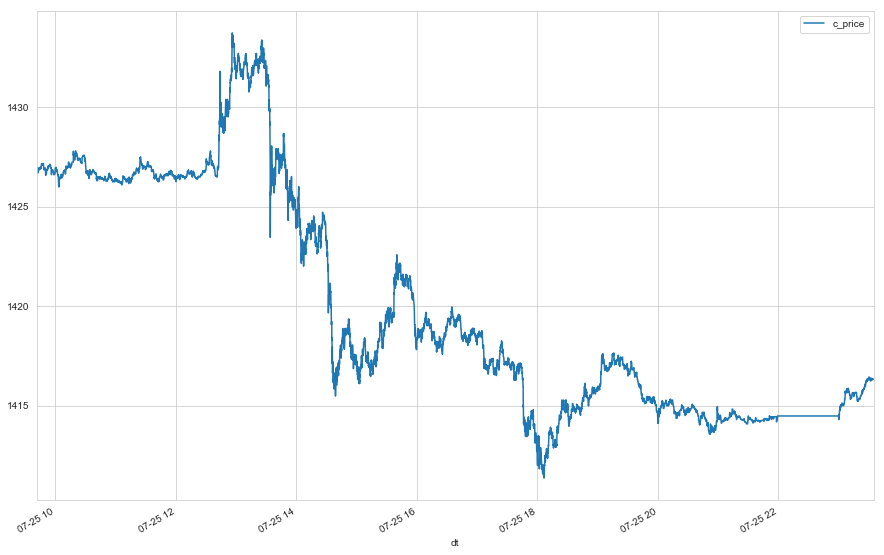

In [11]:
plt.rcParams['figure.figsize'] = [15, 10]
df.plot(kind='line', x='dt', y='c_price')

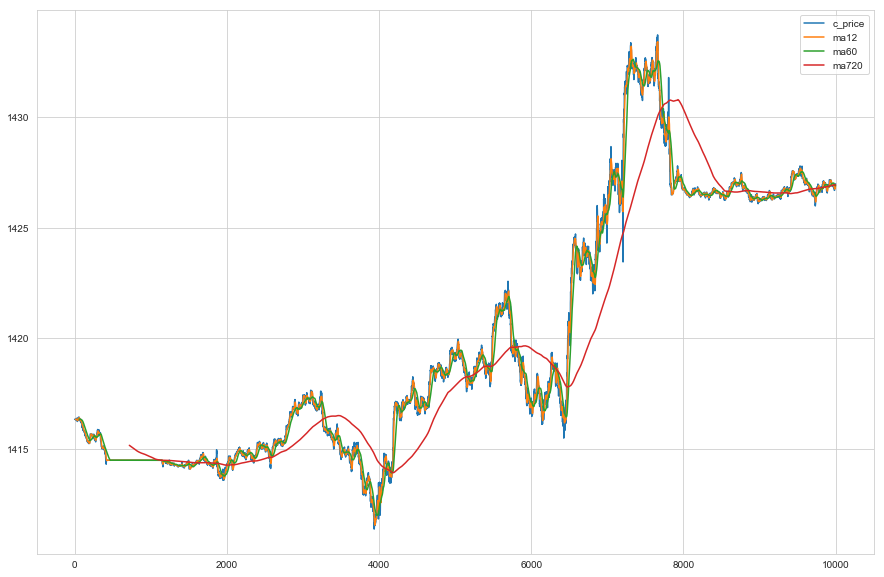

In [12]:
plt.plot(df['c_price'],label= 'c_price')
plt.plot(df['c_price'].rolling(12).mean(),label= 'ma12')
plt.plot(df['c_price'].rolling(60).mean(),label= 'ma60')
plt.plot(df['c_price'].rolling(720).mean(),label= 'ma720') # 1 hour
plt.legend()

In [13]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def moving_average(series, n):

    return np.average(series[-n:])

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    # plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [14]:
df_a = df[['dt','c_price']]

In [15]:
df_a.set_index('dt', inplace=True)

In [16]:
df_a.head(5)

c_price
dt                           
2019-07-25 23:34:43  1416.338
2019-07-25 23:34:38  1416.338
2019-07-25 23:34:33  1416.338
2019-07-25 23:34:28  1416.338
2019-07-25 23:34:23  1416.338

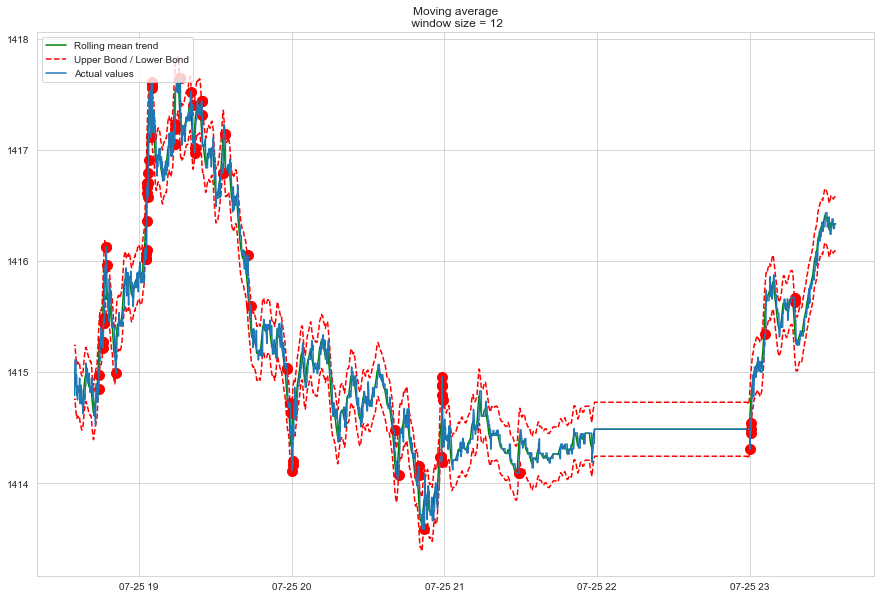

In [17]:
plotMovingAverage(df_a.head(3600), 12, plot_intervals=True, plot_anomalies=True) # 1 hour data with 1 min MA

In [18]:
#df_b = df_a[(df_a['dt'] > '2019-07-25 12:30') & (df_a['dt'] < '2019-07-25 13:30')]
df_b = df_a.loc[(df_a.index > '2019-07-25 13:20:00') & (df_a.index < '2019-07-25 13:40:00')]

In [19]:
df_b.head()

c_price
dt                           
2019-07-25 13:39:58  1427.916
2019-07-25 13:39:53  1427.852
2019-07-25 13:39:48  1427.540
2019-07-25 13:39:43  1427.542
2019-07-25 13:39:38  1427.471

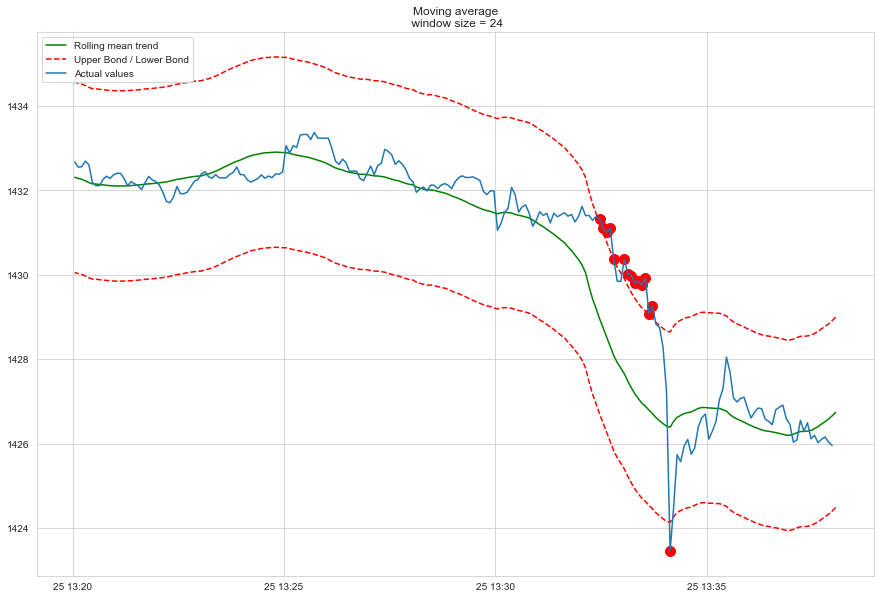

In [20]:
plotMovingAverage(df_b, 24, plot_intervals=True, plot_anomalies=True) # 1 hour data with 1 min MA

In [21]:
df_c = df_b[['c_price']]

In [22]:
df_c.head(1)

c_price
dt                           
2019-07-25 13:39:58  1427.916

In [23]:
sequence_length = 60
epoch = 200
verb = 0 # 0-off

In [24]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        window.index = range(sequence_length)
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [25]:
result = []
for index in range(len(df_c) - sequence_length):
    result.append(df_c['c_price'][index: index + sequence_length])
result = normalise_windows(result)
result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:row, :]
np.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = result[row:, :-1]
y_test = result[row:, -1]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()

model.add(LSTM(
    input_dim = 1,
    output_dim = 100
    ))
model.add(Dense(
    output_dim = 1,
    activation = 'linear'
    ))

model.compile(loss = 'mse', optimizer = 'rmsprop')
model.fit(X_train, y_train, epochs = epoch, validation_split = 0.05, verbose = verb)

W0725 23:35:11.627532 4826248640 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 1), units=100)`
  
W0725 23:35:11.645640 4826248640 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 23:35:11.648712 4826248640 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform 

In [27]:
predictions = model.predict(X_test)
predictions1 = model.predict(X_test)
predictions = np.reshape(predictions, (predictions.size,))
plt.rcParams["figure.figsize"] = (20,10)

In [28]:
last_rclose = df_c.iloc[1]['c_price'] # [1] last, [-1] first

In [29]:
last_rclose

1427.852

In [30]:
df_c.iloc[2]['c_price'] # [1] last, [-1] first

1427.54

In [31]:
from numpy import newaxis
curr_frame = X_test[0]
predicted = []
for i in range(len(X_test)):
    predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
    curr_frame = curr_frame[1:]
    curr_frame = np.insert(curr_frame, len(X_test[0])-1, predicted[-1], axis=0)

Text(0.5, 1.0, 'Next Price - Occurrence / Price')

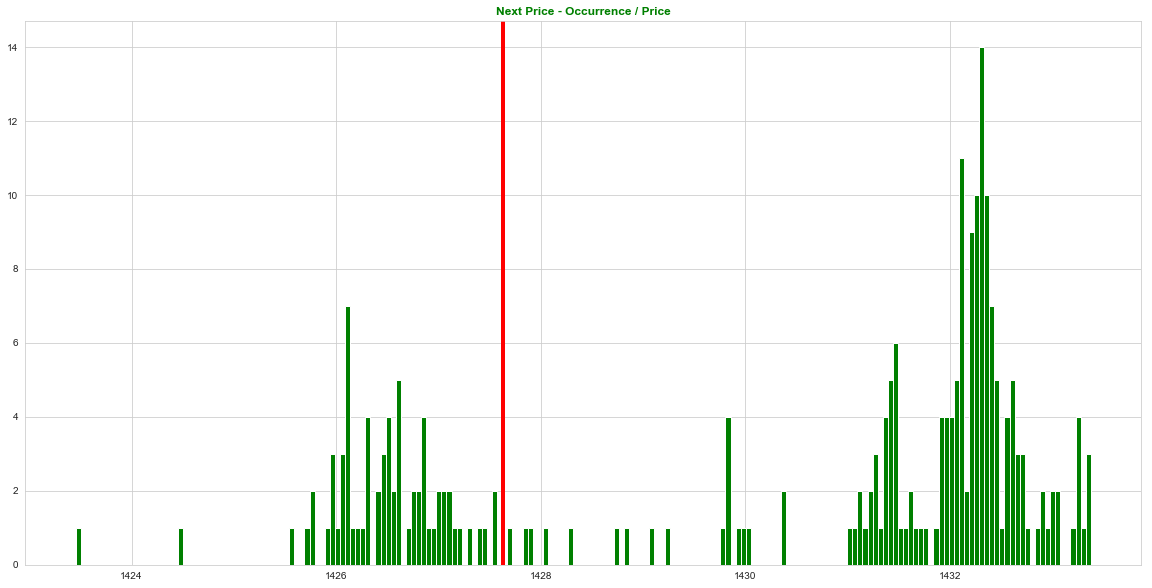

In [32]:
plt.rcParams["figure.figsize"] = (20,10)
q = (curr_frame[0]*last_rclose)+last_rclose

# Now let's plot the distribution of the end prices
plt.hist(df_c['c_price'], bins=200, color='G')

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# For plot title
plt.title(label="Next Price - Occurrence / Price", weight='bold', color='G')

In [33]:
print("Last Price     : ", df_c.iloc[2]['c_price']) # [1] last, [-1] first
print("Predicted Price: ", q[0])
print("Reality Price  : ", last_rclose)
print("Difference:      ", q[0]-last_rclose)

Last Price     :  1427.54
Predicted Price:  1427.6287517429116
Reality Price  :  1427.852
Difference:       -0.2232482570884713


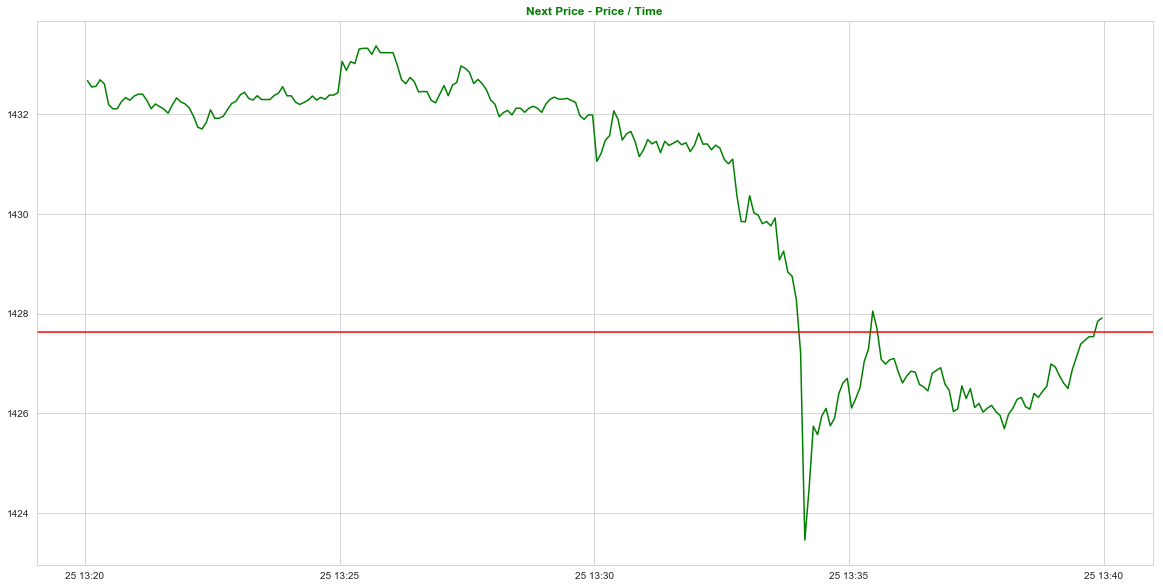

In [34]:
plt.plot(df_c['c_price'], 'g', label = 'curr_frame')
plt.title(label="Next Price - Price / Time", weight='bold', color='G')
plt.axhline(y=q, color='r', linestyle='-')

In [35]:
df_d = df_a.loc[(df_a.index > '2019-07-25 13:40:00') & (df_a.index < '2019-07-25 13:41:00')]

In [36]:
df_d.head(5)

c_price
dt                           
2019-07-25 13:40:58  1427.744
2019-07-25 13:40:53  1427.572
2019-07-25 13:40:48  1427.479
2019-07-25 13:40:43  1427.372
2019-07-25 13:40:38  1427.547

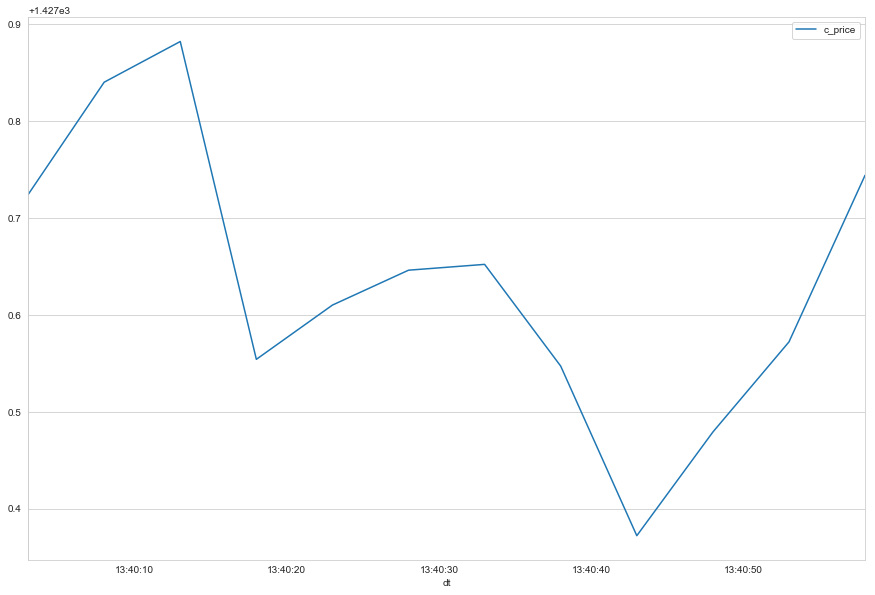

In [37]:
plt.rcParams['figure.figsize'] = [15, 10]
df_d.plot(kind='line', y='c_price')